# Claims — Closed Summary, Open Aging Pareto & Open Tasks (v3.1 — Commented)
**Generated:** 2025-11-05 20:53:15

In [53]:
# Parameters
warehouses = ["OKC", "Atlanta", "Orlando", "Ontario", "El Paso", "Flowood", "Phoenix", "Charlotte"]
start_date = "01-01-2024"
end_date   = "2-1-2026"
max_labels = 25
INPUT_FILES = [
  ("data/inputs/Claims.xlsx", "Ford Claims"),
  ("data/inputs/Chrysler Claims.xlsx", "Chrysler Claims"),
]
OUT_XLSX = "claims_analysis_output.xlsx"
FIG_DIR = "figs_claims"

In [54]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from pathlib import Path
import re
from typing import Optional, Tuple, Dict
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

In [55]:
# Helpers
def safe_filename(name: str, max_len: int = 180) -> str:
    if name is None:
        name = "untitled"
    name = re.sub(r'[<>:"/\\|?*]', "_", str(name))
    name = re.sub(r"[\x00-\x1f]", "_", name)
    name = re.sub(r"_+", "_", name).strip(" .")
    if not name:
        name = "unnamed"
    return name[:max_len]

def find_column(df: pd.DataFrame, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def normalize_columns(df: pd.DataFrame):
    wh_col = find_column(df, ["Bucket Name", "Warehouse", "WH", "Facility"])
    sd_col = find_column(df, ["Start Date", "Open Date", "Opened Date", "Created Date", "Create Date", "Claim Open Date", "Date Opened"])
    cd_col = find_column(df, ["Completed Date", "Close Date", "Closed Date"])
    task_col = find_column(df, ["Task Name", "Task"])
    labels_col = find_column(df, ["Labels", "Label"])
    due_col = find_column(df, ["Due Date", "Due date", "Task Due", "Due"])

    if wh_col is None:
        raise KeyError("Warehouse column not found")
    if sd_col is None:
        raise KeyError("Start/Open date column not found")

    out = df.copy()
    out.rename(columns={wh_col: "Warehouse", sd_col: "Start Date"}, inplace=True)
    if cd_col is not None: out.rename(columns={cd_col: "Completed Date"}, inplace=True)
    else: out["Completed Date"] = pd.NaT
    if task_col is not None: out.rename(columns={task_col: "Task Name"}, inplace=True)
    else: out["Task Name"] = ""
    if labels_col is not None: out.rename(columns={labels_col: "Labels"}, inplace=True)
    else: out["Labels"] = ""
    if due_col is not None: out.rename(columns={due_col: "Due Date"}, inplace=True)
    else: out["Due Date"] = pd.NaT

    out["Start Date"] = pd.to_datetime(out["Start Date"], errors="coerce")
    out["Completed Date"] = pd.to_datetime(out["Completed Date"], errors="coerce")
    out["Due Date"] = pd.to_datetime(out["Due Date"], errors="coerce")
    out["Warehouse"] = out["Warehouse"].astype(str).str.strip()
    out["Task Name"] = out["Task Name"].astype(str).str.strip()
    out["Labels"] = out["Labels"].astype(str)
    return out, {}

In [56]:
def filter_by_warehouses_and_dates(df, warehouses, start_date, end_date):
    wanted = {w.strip().lower(): w for w in warehouses}
    df2 = df[df["Warehouse"].str.lower().isin(wanted.keys())].copy()
    df2["Warehouse"] = df2["Warehouse"].str.lower().map(wanted)
    if start_date:
        df2 = df2[df2["Start Date"] >= pd.to_datetime(start_date)]
    if end_date:
        df2 = df2[df2["Start Date"] <= pd.to_datetime(end_date)]
    return df2

def closed_claims_summary(df, dataset_name):
    closed = df[df["Completed Date"].notna()].copy()
    closed["DaysToClose"] = (closed["Completed Date"] - closed["Start Date"]).dt.days
    agg = closed.groupby("Warehouse", dropna=False)["DaysToClose"].agg(
        CountClosed="count",
        MeanDaysToClose=lambda s: float(np.nanmean(s)) if len(s) else np.nan,
        MedianDaysToClose=lambda s: float(np.nanmedian(s)) if len(s) else np.nan,
        MinDaysToClose=lambda s: float(np.nanmin(s)) if len(s) else np.nan,
        MaxDaysToClose=lambda s: float(np.nanmax(s)) if len(s) else np.nan,
    ).reset_index()
    agg.insert(0, "Dataset", dataset_name)
    return agg

def open_claims_aging_table(df, dataset_name):
    open_df = df[df["Completed Date"].isna()].copy()
    today = pd.Timestamp.today().normalize()
    open_df["AgeDays"] = (today - open_df["Start Date"].dt.normalize()).dt.days
    bucket_labels = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    bins = [-1, 29, 59, 89, float("inf")]
    open_df["Aging Bucket"] = pd.cut(open_df["AgeDays"], bins=bins, labels=bucket_labels, include_lowest=True, right=True)
    counts = (open_df.groupby(["Warehouse", "Aging Bucket"]).size().rename("Count").reset_index())
    all_wh = [w for w in warehouses if w in counts["Warehouse"].unique().tolist()]
    full_index = pd.MultiIndex.from_product([all_wh, bucket_labels], names=["Warehouse", "Aging Bucket"])
    counts = counts.set_index(["Warehouse", "Aging Bucket"]).reindex(full_index, fill_value=0).reset_index()
    counts["Percent"] = counts.groupby("Warehouse")["Count"].transform(lambda x: (x / x.sum() * 100.0) if x.sum() else 0.0)
    counts["CumPercent"] = counts.groupby("Warehouse")["Percent"].cumsum()
    counts.insert(0, "Dataset", dataset_name)
    return counts

def plot_pareto_for_wh(df_aging_wh, dataset_name, wh, max_labels=25, save_dir=FIG_DIR):
    labels = df_aging_wh["Aging Bucket"].astype(str).tolist()
    x = np.arange(len(labels))
    counts = df_aging_wh["Count"].to_numpy(dtype=float)
    cum_pct = df_aging_wh["CumPercent"].to_numpy(dtype=float)
    fig, ax = plt.subplots(figsize=(8, 4.6))
    bars = ax.bar(x, counts)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("Claim Age"); ax.set_ylabel("Open Claims (count)")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax.twinx(); ax2.plot(x, cum_pct, marker="o"); ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100); ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    total = int(np.nansum(counts))
    ax.set_title(f"{dataset_name} — Open Claims Aging — {wh} (n={total})")
    ax.grid(axis="y", linestyle="--", alpha=0.3); fig.tight_layout()
    if len(labels) <= max_labels:
        for rect, val in zip(bars, counts):
            ax.text(rect.get_x()+rect.get_width()/2, rect.get_height(), f"{int(val)}", ha="center", va="bottom", fontsize=9)
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    fname = f"{safe_filename(dataset_name)}__aging_pareto__{safe_filename(wh)}.png"
    fig.savefig(Path(save_dir)/fname, dpi=150, bbox_inches="tight"); plt.show()

def extract_wh_actions(labels_value: str):
    parts = re.split(r"[;|,]", str(labels_value))
    wh_only = []
    for p in parts:
        s = p.strip()
        if re.match(r"(?i)^WH\b", s):
            wh_only.append(s)
    return wh_only

In [57]:
# Load/standardize/combine/compute
combined_rows = []
closed_summaries = []
open_aging_tables = []

for rel_path, dname in INPUT_FILES:
    path = Path(rel_path)
    if not path.exists():
        print(f"WARNING: File not found, skipping: {rel_path}")
        continue
    raw = pd.read_excel(path)
    df_std, _ = normalize_columns(raw)
    df_comb = raw.copy()
    for col in ["Warehouse", "Start Date", "Completed Date", "Task Name", "Labels", "Due Date"]:
        if col in df_std.columns:
            df_comb[col] = df_std[col]
    df_comb["Dataset"] = dname
    combined_rows.append(df_comb)
    df_std_f = filter_by_warehouses_and_dates(df_std, warehouses, start_date, end_date)
    closed_summaries.append(closed_claims_summary(df_std_f, dname))
    open_aging_tables.append(open_claims_aging_table(df_std_f, dname))

combined_all = pd.concat(combined_rows, ignore_index=True) if combined_rows else pd.DataFrame()
if not combined_all.empty:
    mask = combined_all["Warehouse"].notna()
    if start_date:
        mask &= pd.to_datetime(combined_all["Start Date"], errors="coerce") >= pd.to_datetime(start_date)
    if end_date:
        mask &= pd.to_datetime(combined_all["Start Date"], errors="coerce") <= pd.to_datetime(end_date)
    wanted = {w.strip().lower() for w in warehouses}
    mask &= combined_all["Warehouse"].astype(str).str.lower().isin(wanted)
    combined_all_filtered = combined_all[mask].copy()
else:
    combined_all_filtered = combined_all

closed_all = pd.concat(closed_summaries, ignore_index=True) if closed_summaries else pd.DataFrame()
aging_all  = pd.concat(open_aging_tables, ignore_index=True) if open_aging_tables else pd.DataFrame()
combined_all_filtered.head(10), closed_all.head(5), aging_all.head(5)

C:\Users\dbalan\AppData\Local\Temp\ipykernel_23028\4085303659.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (open_df.groupby(["Warehouse", "Aging Bucket"]).size().rename("Count").reset_index())
C:\Users\dbalan\AppData\Local\Temp\ipykernel_23028\4085303659.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (open_df.groupby(["Warehouse", "Aging Bucket"]).size().rename("Count").reset_index())


(                         Task ID  \
 0   -0qzZOLigUCL_5_jyscqrWUAEUa6   
 10  -ACtth5XYk-YBOHBOfGOZWUAO5tw   
 12  -BqKPgJEi0Gx20NJYswqvWUAO5vr   
 13  -DdktK4Nakq-c5o9lwE7lmUAMlBn   
 23  -QVLWG6S0EGIJMLIQ4wqF2UAEMPN   
 26  -VzlWQS5UkyFFEPdmI5H1WUAG_kb   
 27  -WCUda3dEEeIb2Ea67mJVWUALl71   
 30  -YTAGi8adUCPkEnn3dXc9GUAC51o   
 31  -ZDeNiWz5k-WJug1SdAfAGUAOs5p   
 34  -bxFt9zibEu0qsnAv0qo_WUANatP   
 
                                             Task Name Bucket Name   Progress  \
 0   CHARLOTTE - CHRYSLER SHORTAGE - 1308667 - 6843...   Charlotte  Completed   
 10  LK4Z7000DA - #05534 - FRIENDLY FORD - S39-0135...     Phoenix  Completed   
 12  CHRYSLER SHORTAGE - PO 1305881 - 68311108AE - ...     Ontario  Completed   
 13  CHRYSLER SHORTAGE - PO 1272888 - R8149703AJ - ...         OKC  Completed   
 23  ONTARIO - PO# 160988 - INV T71347 - PART  LC3Z...     Ontario  Completed   
 26  PO# 113210/159488 - S04424 - JC3Z6006B (860941...   Charlotte  Completed   
 27  CHRYSLER SHORTAGE -

In [58]:
# Open Tasks – detail & aggregate
open_task_rows = []
for rel_path, dname in INPUT_FILES:
    path = Path(rel_path)
    if not path.exists():
        continue
    raw = pd.read_excel(path)
    df_std, _ = normalize_columns(raw)
    df_std_f = filter_by_warehouses_and_dates(df_std, warehouses, start_date, end_date)
    open_df = df_std_f[df_std_f["Completed Date"].isna()].copy()
    open_df["ActionList"] = open_df["Labels"].apply(extract_wh_actions)
    open_df = open_df[open_df["ActionList"].map(len) > 0].copy().explode("ActionList")
    open_df.rename(columns={"ActionList":"Action Required"}, inplace=True)
    open_df["Dataset"] = dname
    open_task_rows.append(open_df[["Dataset","Warehouse","Task Name","Action Required","Due Date"]])

open_tasks_detail = pd.concat(open_task_rows, ignore_index=True) if open_task_rows else pd.DataFrame(columns=["Dataset","Warehouse","Task Name","Action Required","Due Date"])
if not open_tasks_detail.empty:
    open_tasks_detail = open_tasks_detail.sort_values(["Action Required","Due Date","Warehouse"], na_position="last").reset_index(drop=True)

if not open_tasks_detail.empty:
    open_tasks_agg = (open_tasks_detail.groupby(["Dataset","Warehouse","Action Required"], dropna=False).size().rename("Count").reset_index()
                      .sort_values(["Warehouse","Count"], ascending=[True, False], ignore_index=True))
else:
    open_tasks_agg = pd.DataFrame(columns=["Dataset","Warehouse","Action Required","Count"])

open_tasks_detail.head(10), open_tasks_agg.head(10)

(       Dataset Warehouse                                          Task Name  \
 0  Ford Claims   Phoenix  GC4Z6007FARM - PO 170785 - 08972 - LHM FORD MF...   
 1  Ford Claims   Atlanta  GC4Z6007FARM - PO 170983 - 00348 - RIVERSIDE F...   
 2  Ford Claims   Ontario  KB3Z7000ARM - PO 171668 - 07944 - MULLAHEY FOR...   
 3  Ford Claims   Orlando  HC4Z7000C - 02159 - PALMETTO FORD OF MIAMI - S...   
 4  Ford Claims   Flowood  LC3Z7000HB - PO 172333 - 06531 - LAMARQUE FORD...   
 5  Ford Claims   Flowood  FL3Z6006FARM - 03209 - GRAY DANIELS FORD LLC -...   
 6  Ford Claims   Ontario  6C3Z6009ARM - PO 171316- 09681 - DAVID WILSONS...   
 7  Ford Claims   Phoenix  5C3Z7000MRM - PO 173688 - 20301 - SANDERSON RE...   
 8  Ford Claims   Phoenix  LC3Z6006B - PO 173047 - 06067 - CHAPMAN FORD -...   
 9  Ford Claims   Phoenix  JC3Z7000JRM - PO 171512 - 05534 - FRIENDLY FOR...   
 
       Action Required   Due Date  
 0  WH P/U from Dealer 2026-01-02  
 1  WH P/U from Dealer 2026-01-23  
 2  WH P/U

In [59]:
# Export all outputs to Excel (overwrites file each run to avoid stale data)
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as writer:
    if not combined_all_filtered.empty:
        combined_all_filtered.to_excel(writer, sheet_name="All_Claims_Combined", index=False)
    if not closed_all.empty:
        closed_all.to_excel(writer, sheet_name="Closed_Claims_Summary", index=False)
    if not aging_all.empty:
        aging_all.to_excel(writer, sheet_name="Open_Claims_Aging", index=False)

    # Leadership-friendly rollup: Ford vs Chrysler open-claims aging by warehouse
    if not aging_all.empty:
        bucket_order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
        _keep = set(["Ford Claims", "Chrysler Claims"])
        aging_fc = aging_all[aging_all["Dataset"].isin(_keep)].copy()
        aging_summary = (
            aging_fc
            .pivot_table(
                index=["Dataset", "Warehouse"],
                columns="Aging Bucket",
                values="Count",
                aggfunc="sum",
                fill_value=0
            )
            .reindex(columns=bucket_order, fill_value=0)
            .reset_index()
        )
        aging_summary["Total Open Claims"] = aging_summary[bucket_order].sum(axis=1)
        aging_summary["% >= 90 days"] = np.where(
            aging_summary["Total Open Claims"] > 0,
            aging_summary[">= 90 days"] / aging_summary["Total Open Claims"],
            np.nan
        )
        aging_summary.to_excel(writer, sheet_name="Open_Aging_Summary", index=False)
    if not open_tasks_detail.empty:
        open_tasks_detail.to_excel(writer, sheet_name="Open_Tasks_By_Warehouse", index=False)
    if not open_tasks_agg.empty:
        open_tasks_agg.to_excel(writer, sheet_name="Open_Tasks_Aggregate", index=False)
print(f"Wrote: {OUT_XLSX}")

Wrote: claims_analysis_output.xlsx


In [62]:
# --- Summary table: Open claims aging by warehouse (Ford vs Chrysler) ---
# This rolls up the open-claims aging buckets into a single, leadership-friendly table
# BEFORE generating the Pareto charts below.

if aging_all.empty:
    print("No open-claims aging data to summarize (aging_all is empty).")
else:
    bucket_order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    # Keep only the two datasets you care about (aligned with INPUT_FILES labels)
    _keep = set(["Ford Claims", "Chrysler Claims"])
    aging_fc = aging_all[aging_all["Dataset"].isin(_keep)].copy()

    aging_summary = (
        aging_fc
        .pivot_table(
            index=["Dataset", "Warehouse"],
            columns="Aging Bucket",
            values="Count",
            aggfunc="sum",
            fill_value=0
        )
        .reindex(columns=bucket_order, fill_value=0)
        .reset_index()
    )
    aging_summary["Total Open Claims"] = aging_summary[bucket_order].sum(axis=1)
    aging_summary["% >= 90 days"] = np.where(
        aging_summary["Total Open Claims"] > 0,
        aging_summary[">= 90 days"] / aging_summary["Total Open Claims"],
        np.nan
    )

    aging_summary.to_excel(
    "claims_aging_by_warehouse_summary.xlsx",
    index=False
)


    display(
        aging_summary
        .sort_values(["Dataset", "Total Open Claims"], ascending=[True, False])
        .reset_index(drop=True)
    )


Aging Bucket,Dataset,Warehouse,<30 days,30-<60 days,60-<90 days,>= 90 days,Total Open Claims,% >= 90 days
0,Chrysler Claims,Charlotte,2,3,1,25,31,0.806452
1,Chrysler Claims,Ontario,2,3,3,18,26,0.692308
2,Chrysler Claims,Flowood,5,2,2,14,23,0.608696
3,Chrysler Claims,Orlando,2,6,1,14,23,0.608696
4,Chrysler Claims,Phoenix,0,2,2,18,22,0.818182
5,Chrysler Claims,Atlanta,1,2,0,10,13,0.769231
6,Chrysler Claims,OKC,1,0,0,8,9,0.888889
7,Chrysler Claims,El Paso,1,0,1,4,6,0.666667
8,Ford Claims,Atlanta,7,2,2,3,14,0.214286
9,Ford Claims,Orlando,4,1,3,2,10,0.200000


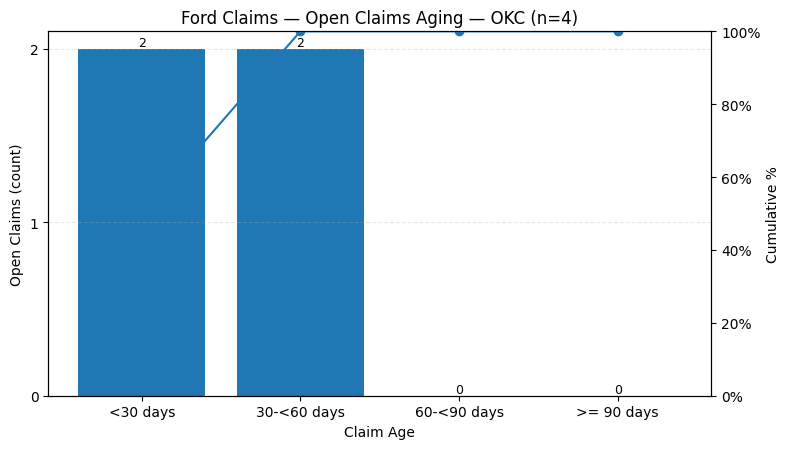

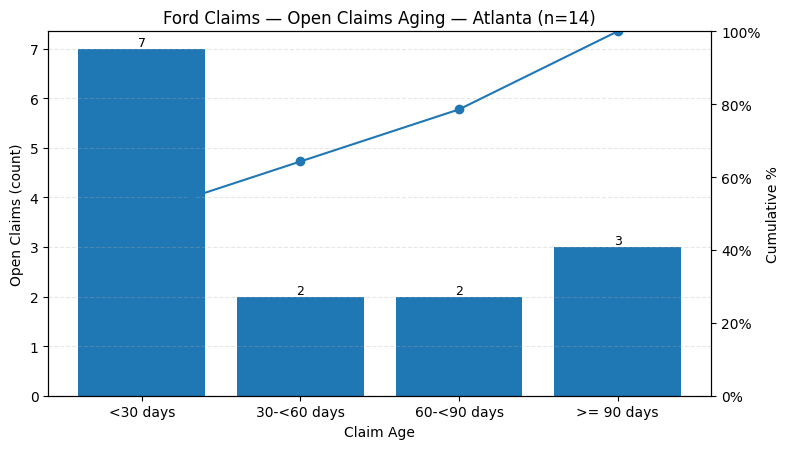

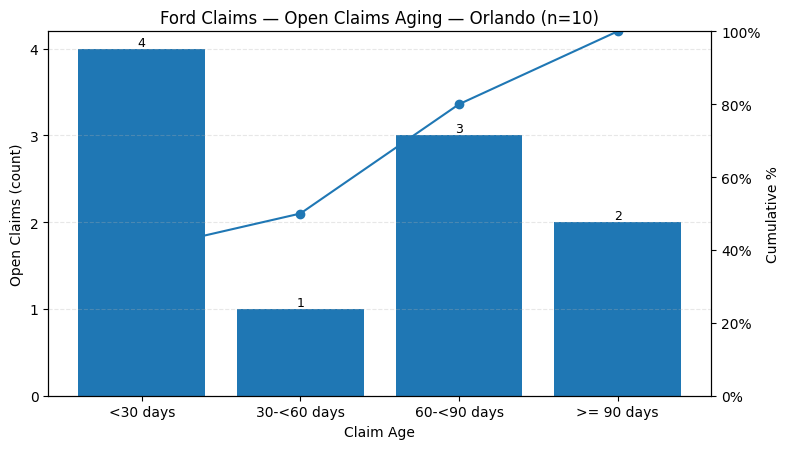

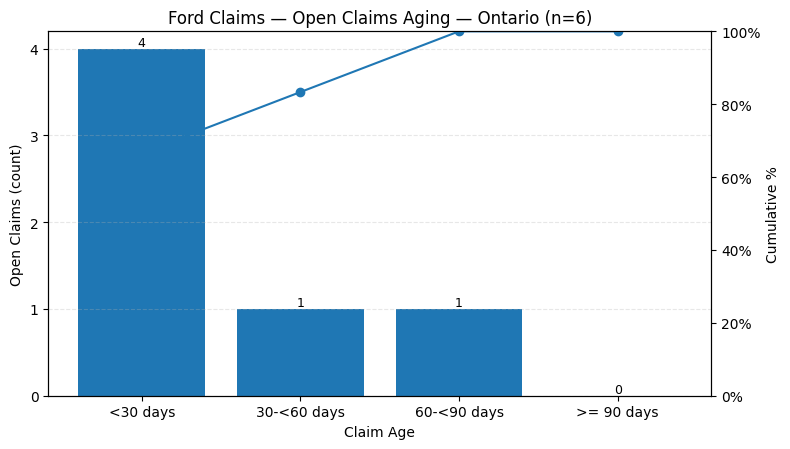

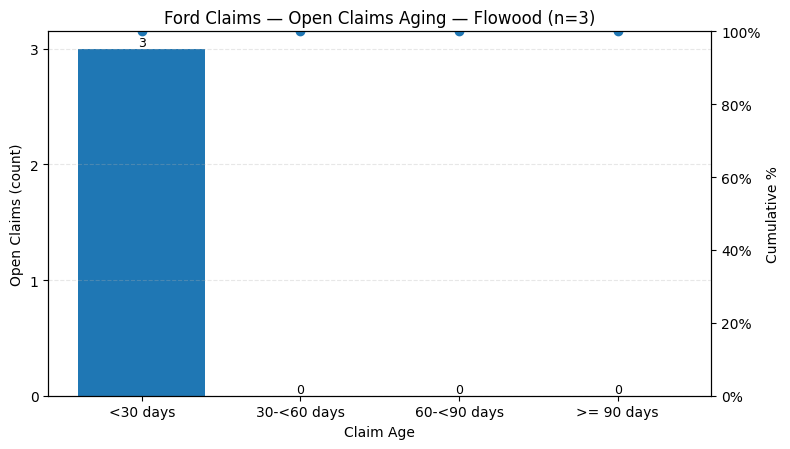

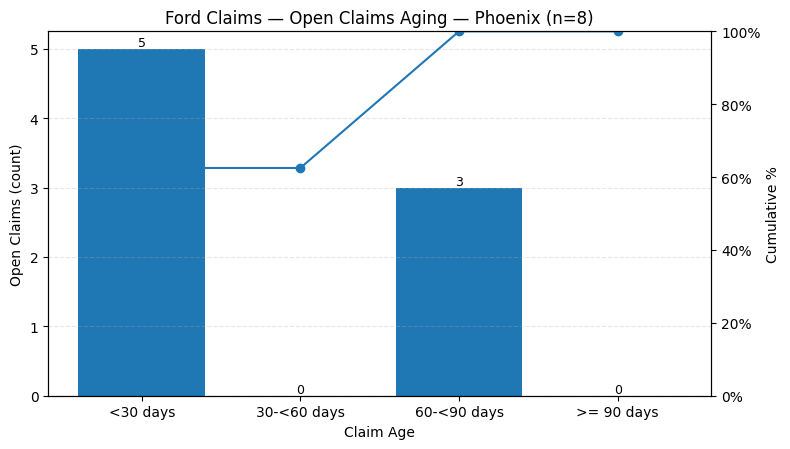

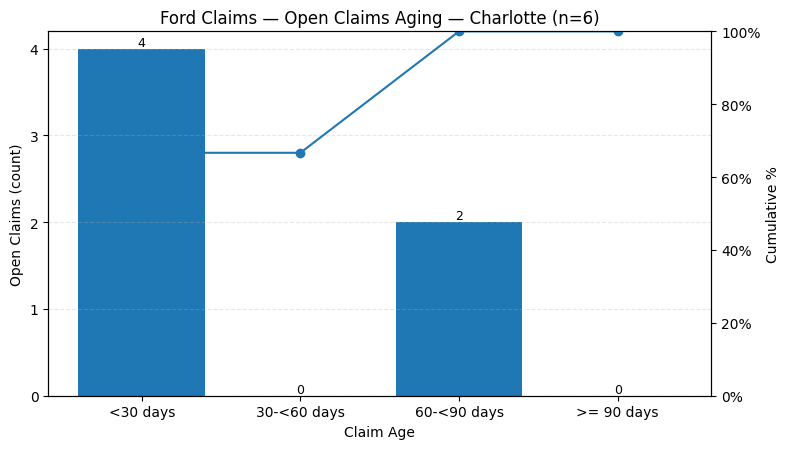

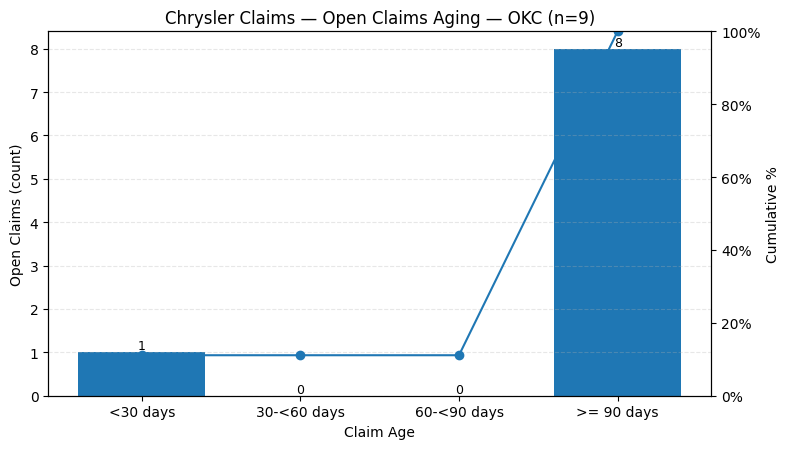

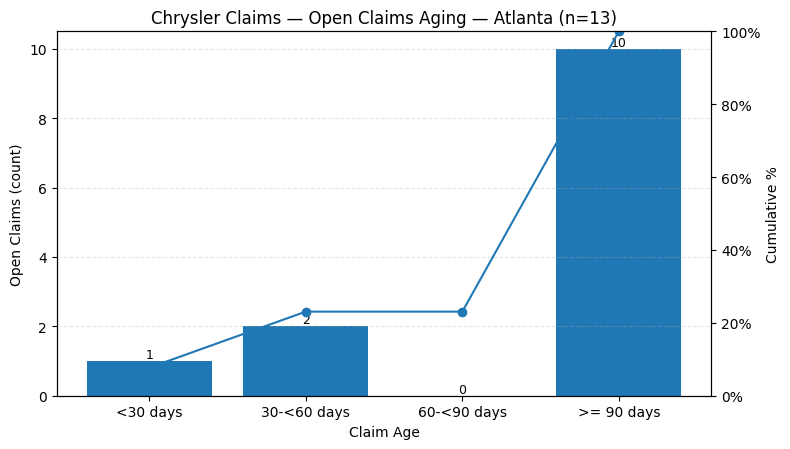

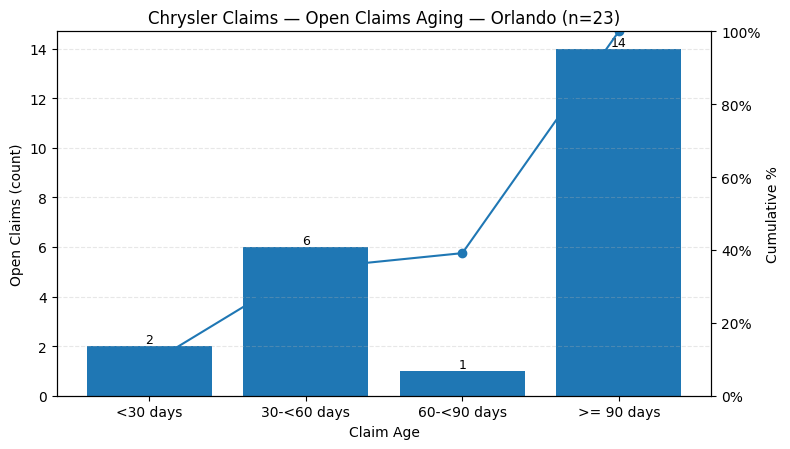

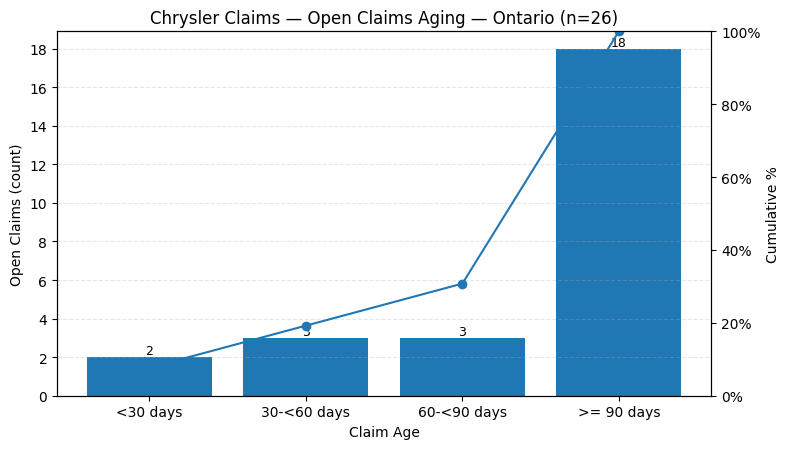

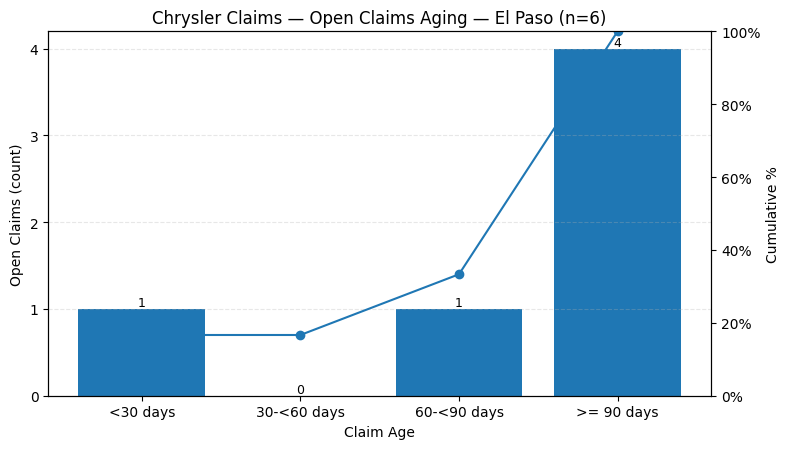

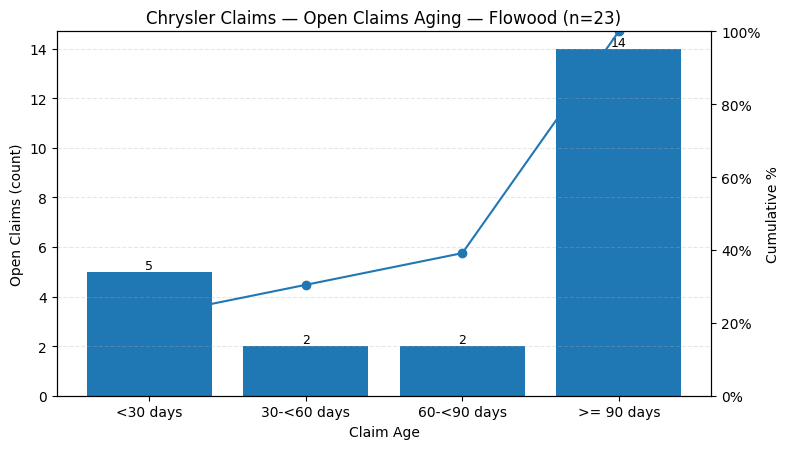

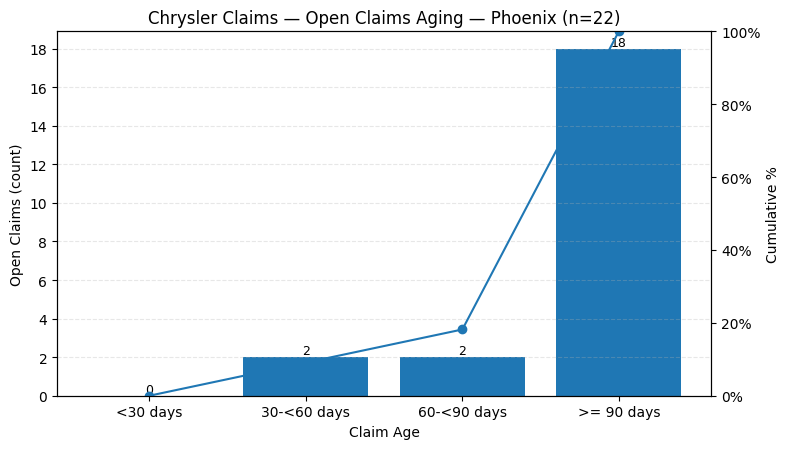

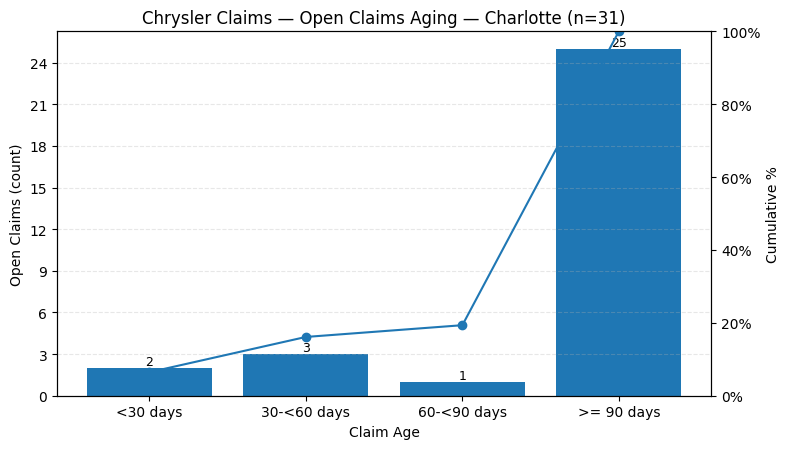

In [61]:
# Pareto chart generation
if not aging_all.empty:
    desired_order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    for dname in aging_all["Dataset"].unique():
        sub = aging_all[aging_all["Dataset"] == dname]
        for wh in warehouses:
            wh_rows = sub[sub["Warehouse"] == wh]
            if wh_rows.empty:
                continue
            wh_rows = wh_rows.set_index("Aging Bucket").reindex(desired_order).reset_index()
            plot_pareto_for_wh(wh_rows, dname, wh, max_labels=max_labels, save_dir=FIG_DIR)
else:
    print("No aging data to plot.")